# DKRZ tutorial

# Plot orography with different resolutions

**Learning content**

- write/use functions
- read netCDF files
- mask variables by another variable
- plot data of two different grid resolutions
- plot polylines

### Grid description:

```
1. The first grid is a low resolution regional grid (CORDEX AFR-44)

    curvilinear              : points=47294 (214x221)
                              lon : -29.04 to 64.68 by 0.44 degrees_east
                              lat : -50.16 to 46.64 by 0.44 degrees_north
                          mapping : rotated_latitude_longitude
                             rlon : -29.04 to 64.68 by 0.44 degrees
                             rlat : -50.16 to 46.64 by 0.44 degrees

1. The second grid is a high resolution regional grid (CORDEX EUR-11)

    curvilinear              : points=174688 (424x412)
                              lon : -44.59386 to 64.96438 degrees_east
                              lat : 21.98783 to 72.585 degrees_north
                        available : cellbounds
                          mapping : rotated_latitude_longitude
                             rlon : -28.375 to 18.155 by 0.11 degrees
                             rlat : -23.375 to 21.835 by 0.11 degrees
```

2022 copyright DKRZ, kmf

<br>

----


## Import packages:

In [1]:
import os
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Function create_plot()


In [2]:
def create_plot(lon, lat, data, transform=ccrs.PlateCarree()):
    global fig, ax
    global plot_parameter

    if 'projection' not in plot_parameter:
        projection = ccrs.PlateCarree()
    else:
        projection = plot_parameter['projection']
    
    if 'figsize' not in plot_parameter:
        figsize = (14,13)
    else:
        figsize = plot_parameter['figsize']
    if 'title' not in plot_parameter:
        title = ' '
    else:
        title = plot_parameter['title']
        
    fig, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=figsize)

    if 'extent' not in plot_parameter:
        extent = ax.set_global()
    else:
        extent = ax.set_extent(plot_parameter['extent'])
        
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAND)
    
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='k', zorder=3)
    gl.xlabel_style = {'size':10}
    gl.ylabel_style = {'size':10}
    gl.top_labels   = True
    gl.right_labels = True
    
    plt.title(title, fontsize=22, y=1.05)
    
    plot = ax.pcolormesh(lon, lat, data, 
                         cmap='terrain', 
                         vmin=-800, 
                         vmax=3000,
                         transform=transform)
    
    cbar = fig.colorbar(plot, ax=ax, label='[m]', shrink=0.4)

## Function add_plot()


In [3]:
def add_plot(lon, lat, data, transform=ccrs.PlateCarree()):
    ax.pcolormesh(lon, lat, data, 
                  cmap='terrain', 
                  vmin=-800, 
                  vmax=3000,
                  transform=transform)

## Function draw_edges()



In [4]:
def draw_edges(lon2d, lat2d, transform=ccrs.PlateCarree()):
    #-- Define edges of regional data:
    if len(lon2d.shape) == 2:
        nlat  = len(lat2d[:,0])
        nlon  = len(lon2d[0,:])
    
        lon_val_lower = lon2d[0,:]
        lon_val_right = lon2d[:,nlon-1]
        lon_val_left  = lon2d[:,0]
        lon_val_upper = lon2d[nlat-1,:]
    
        lat_val_lower = lat2d[0,:]
        lat_val_right = lat2d[:,nlon-1]
        lat_val_left  = lat2d[:,0]
        lat_val_upper = lat2d[nlat-1,:]

        #-- Generate the data for the edges of the regional grid
        line_lons = np.append([lon_val_upper], [lon_val_right[::-1]])
        line_lons = np.append([line_lons], [lon_val_lower])
        line_lons = np.append([line_lons], [lon_val_left])
        line_lats = np.append([lat_val_upper], [lat_val_right[::-1]])
        line_lats = np.append([line_lats], [lat_val_lower])
        line_lats = np.append([line_lats], [lat_val_left])
    elif len(lon2d.shape) == 1:
        lon_val_right = lon2d[-1]
        lon_val_left  = lon2d[0]
        lat_val_lower = lat2d[0]
        lat_val_upper = lat2d[-1]

        line_lons = np.array([lon_val_left,  lon_val_right, lon_val_right, lon_val_left])
        line_lats = np.array([lat_val_lower, lat_val_lower, lat_val_upper, lat_val_upper])

    polyline = np.zeros((len(line_lons),2), np.float64)
    polyline[:,0] = line_lons
    polyline[:,1] = line_lats
    
    #-- add a polyline around the regional grid
    lw, ec, fc = 1, 'k', 'y'     #-- linewidth, edgecolor, facecolor
    
    poly = ax.add_patch(mpatches.Polygon(polyline,
                                         closed=True,
                                         fill=False,
                                         linewidth=lw,
                                         edgecolor=ec,
                                         facecolor=fc,
                                         transform=transform))

## Global plot parameter

In [5]:
plot_parameter = {}

map_proj = ccrs.Orthographic(central_latitude=20.0, central_longitude=10.0)
map_proj._threshold /= 100.

plot_parameter['projection'] = map_proj

# 1. CORDEX AFR-44

    Orographie variable:        HSURF
    Land sea fraction variable: FR_LAND  (range 0. to 1.)


In [6]:
file_name1 = os.environ['HOME']+'/NCL/DKRZ_Workshop/data/HSURF_AFR-44_model_region.nc'
mask_name1 = os.environ['HOME']+'/NCL/DKRZ_Workshop/data/FR_LAND_AFR-44_model_region.nc'

ds1      = xr.open_dataset(file_name1)
ds1_mask = xr.open_dataset(mask_name1)

lon1 = ds1.rlon
lat1 = ds1.rlat

### Mask the orography by the land sea fraction data

In [7]:
land_only1 = ds1.HSURF[0,:,:].where(ds1_mask.FR_LAND[0,:,:] > 0.5)   #-- mask: 0 or 1

### Create the plot

In [8]:
plot_parameter['title'] = 'CORDEX AFR-44: orography'

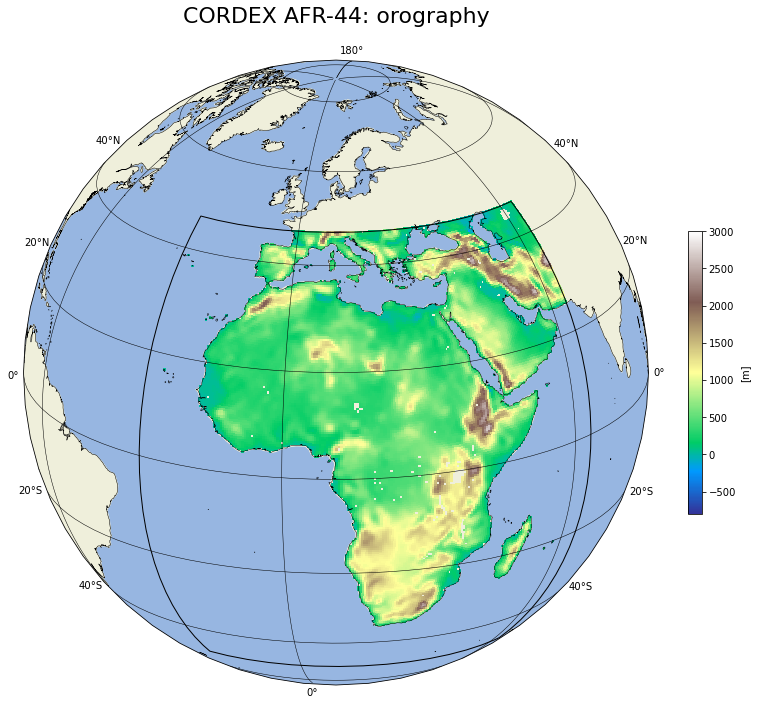

In [9]:
create_plot(lon1, lat1, land_only1)

draw_edges(lon1, lat1)

# 2. CORDEX EUR-11


    Orographie variable:        orog
    Land sea fraction variable: sftlf  (range 0 to 100)


In [10]:
file_name2 = os.environ['HOME']+\
            '/data/CORDEX/EUR-11/orog_EUR-11_MPI-M-MPI-ESM-LR_historical_r0i0p0_CLMcom-CCLM4-8-17_v1_fx.nc'
mask_file2 = os.environ['HOME']+\
             '/data/CORDEX/EUR-11/sftlf_EUR-11_MPI-M-MPI-ESM-LR_historical_r0i0p0_CLMcom-CCLM4-8-17_v1_fx.nc'

ds2 = xr.open_dataset(file_name2)
ds2_mask = xr.open_dataset(mask_file2)

### Read coordinate data for lon and lat

In [11]:
lat2 = ds2.lat
lon2 = ds2.lon

### Create land-sea-mask

Create a land-sea-mask and show only the data over land. The land area fraction (sftlf) values are in range 0 to 100 (%).

In [12]:
land_only2 = ds2.orog.where(ds2_mask.sftlf > 50)   #-- mask: range 0 to 100

### Create the plot

In [13]:
plot_parameter['title'] = 'CORDEX EUR-11: orography'

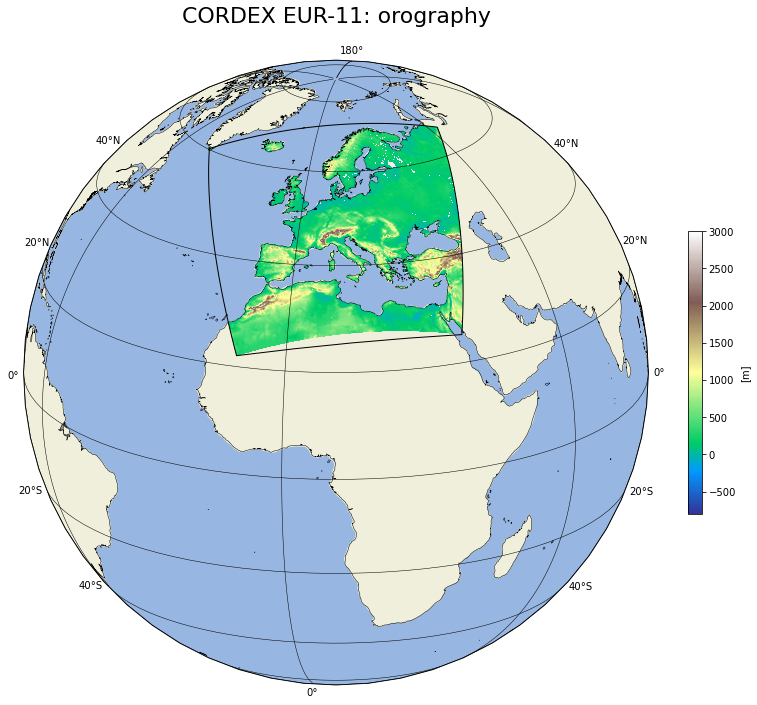

In [14]:
create_plot(lon2, lat2, land_only2)

draw_edges(lon2, lat2, transform=ccrs.Geodetic())

## Zoom into the map

Get the minimum and maximum of the grid area.

```
lon : -44.59386 to 64.96438 degrees_east
lat :  21.98783 to 72.585   degrees_north
```

In [15]:
reslon = !cdo -s sinfon $file_name1 | grep ' lon :' | cut -d ':' -f2
minlon, maxlon = float(reslon[0].split()[0]), float(reslon[0].split()[2])

reslat = !cdo -s sinfon $file_name2 | grep ' lat :' | cut -d ':' -f2
minlat, maxlat = float(reslat[0].split()[0]), float(reslat[0].split()[2])

border = 2
plot_parameter['extent'] = [minlon-border, maxlon+border, minlat-border-10, maxlat+border+5]
print(plot_parameter['extent'])

[-31.04, 66.68, 9.987829999999999, 79.585]


### Create the plot

In [16]:
plot_parameter['title'] = 'CORDEX EUR-11: orography'

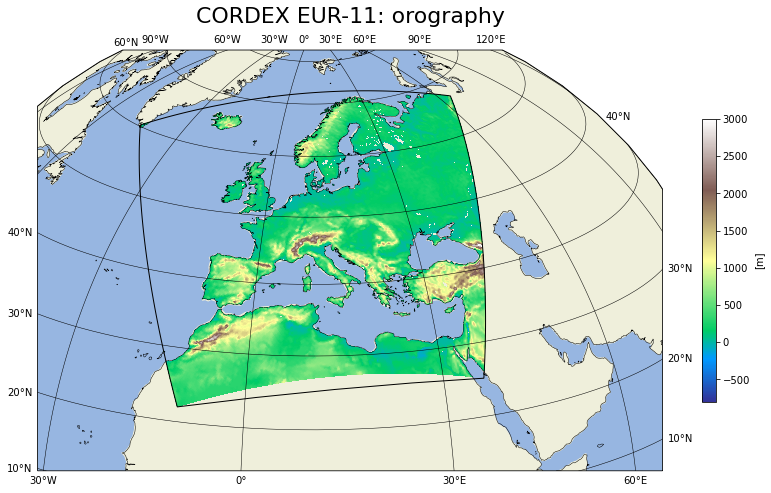

In [17]:
create_plot(lon2, lat2, land_only2)

draw_edges(lon2, lat2, transform=ccrs.Geodetic())

## Plot CORDEX AFR-44 and EUR-11 together

In [18]:
plot_parameter['title'] = 'CORDEX EUR-11 and AFR-44: orography'

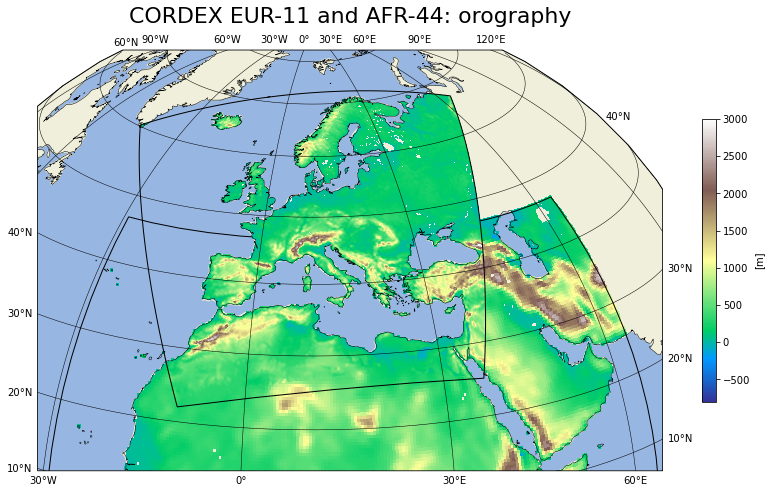

In [19]:
create_plot(lon1, lat1, land_only1)
draw_edges(lon1, lat1)

add_plot(lon2, lat2, land_only2)
draw_edges(lon2, lat2, transform=ccrs.Geodetic())